# Data Preprocessing

## Installing Necessary Libraries

In [32]:
pip install stop_words

  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=f6af9f24c606dbb9fba7fd29540334cce1dd7fc7b058da1a68fc919ef9042bd3
  Stored in directory: /Users/CRYPTO/Library/Caches/pip/wheels/8f/a5/51/a5405e1da5d178491b79d12cc81b6cb9bb14fe2c8c632eba70
Successfully built stop_words
Note: you may need to restart the kernel to use updated packages.


In [55]:
pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 4.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=4e2b20b8f716665f18e20def69dea86f9212dd70c177f89983bbaec511d78b66
  Stored in directory: /Users/CRYPTO/Library/Caches/pip/wheels/5e/90/99/807a5ad861ce5d22c3c299a11df8cba9f31524f23ae6e645cb
Successfully built autocorrect
Note: you may need to restart the kernel to use updated packages.


In [48]:
pip install pyspellchecker

  Obtaining dependency information for pyspellchecker from https://files.pythonhosted.org/packages/e1/d2/c7e3b3a61a34b9320399fa731d1f9f0c73db8a1f28c6764e9e11efa68a29/pyspellchecker-0.8.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 7.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


## Importing Libraries

In [1]:
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
tqdm.pandas()

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string
from stop_words import get_stop_words
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer(language='english')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller

[nltk_data] Downloading package punkt to /Users/CRYPTO/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/CRYPTO/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Analyze the Dataset

In [2]:
df = pd.read_csv('Original_Reddit.csv')
print("Column names:", df.columns)

Column names: Index(['id', 'text', 'hate_speech_idx', 'response'], dtype='object')


In [3]:
df.head()

,id,text,hate_speech_idx,response
0,1. e8q18lf\n2. \te8q9w5s\n3. \t\te8qbobk\n4. \...,1. A subsection of retarded Hungarians? Ohh bo...,[1],"[""I don't see a reason why it's okay to insult..."
1,1. e9c6naz\n2. \te9d03a5\n3. \t\te9d8e4d\n,"1. > ""y'all hear sumn?"" by all means I live i...",[3],['Persons with disabilities is the accepted te...
2,1. e84rl2i\n2. \te84w60l\n3. \t\te8544rn\n4. \...,1. wouldn't the defenders or whatever they are...,NaN,NaN
3,1. e7kq72n\n2. \te7m24ar\n,1. Because the Japanese aren't retarded and kn...,[1],"[""It's not right for anyone of any gender to b..."
4,1. e7hdgoh\n2. \te7iyj6a\n3. \t\te7j6iho\n4. \...,1. That might be true if we didn't have an exa...,"[2, 3]","[""You shouldn't be bringing up sensitive topic..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               5020 non-null   object
 1   text             5020 non-null   object
 2   hate_speech_idx  3847 non-null   object
 3   response         3847 non-null   object
dtypes: object(4)
memory usage: 157.0+ KB


### Each row of text contains more than 1 comment.

In [5]:
df['text'][17]

'1. Grammatical errors, overt racism, child prostitution.. It would appear we have a despicable moron on our hands. \n'

In [6]:
df['text'][1]

'1. > "y\'all hear sumn?"  by all means I live in a small town rn (for work). 5k people here, originally a mining community. No one is protesting here. Nobody mentioned the protest today. Nobody here cares, they\'re busy loving their family and working hard.  Thank god for the electoral college. Liberals think we don\'t matter. \n2. \t[removed]\n3. \t\tah a liberal has slipped in. you can tell because the first question asked was loaded and retarded.  >  What does "working hard" mean? Your political views get more validated by how much manual labour you put in?   where did I say that? and yes, of course you have no clue what "working hard" means. Few soyboys do.  > Based on your comment regarding the EC I guess you don\'t really think that 2 mil majority of people who voted for Hillary don\'t really matter.  I shouldn\'t have to explain to you the point of the EC. If you want to talk to someone who is more patient with you than I am, you can check out AskThe_Donald. \n'

### The corresponding hate speech index determines which comments are categorized as hate speech.

In [7]:
df['hate_speech_idx'][17]

nan

In [8]:
df['hate_speech_idx'][1]

'[3]'

### Statistics

In [9]:
df['text'].describe()

count                   5020
unique                  5002
top       1. What a cunt. \n
freq                       4
Name: text, dtype: object

In [10]:
df['hate_speech_idx'].describe()

count     3847
unique     316
top        [1]
freq      1740
Name: hate_speech_idx, dtype: object

## Restructuring the Dataset

### Restructuring the dataset to have individual rows for each comment from a post, tagging them with a 1 if they contain hate speech and 0 if not.

In [11]:
# Function to split comments and mark hate speech
def process_comments(row):
    # Using regex to find the pattern "index. comment"
    pattern = re.compile(r'(\d+)\.\s(.*?)(?=\d+\.\s|$)', re.DOTALL)
    matches = pattern.findall(row['text'])
    
    # Clean and split the hate_speech_idx column
    hate_indices = list(map(int, re.sub(r'[^0-9,]', '', row['hate_speech_idx']).split(','))) if pd.notna(row['hate_speech_idx']) else []
    
    processed_data = []
    
    for index, comment in matches:
        index = int(index)
        comment = comment.strip()
        is_hate_speech = 1 if index in hate_indices else 0
        processed_data.append([index, comment, is_hate_speech])
    
    return processed_data

processed_comments = df.apply(process_comments, axis=1)
processed_comments = [item for sublist in processed_comments for item in sublist]
new_df = pd.DataFrame(processed_comments, columns=['index','comment', 'hate_speech'])

new_df.to_csv('Restructure_Reddit.csv', index=False)
print("Processing complete. New CSV file saved.")

Processing complete. New CSV file saved.


## Import Processed Dataset

In [12]:
df = pd.read_csv('Restructure_Reddit.csv')
print("Column names:", df.columns)

Column names: Index(['index', 'comment', 'hate_speech'], dtype='object')


In [13]:
df.head()

,index,comment,hate_speech
0,1,A subsection of retarded Hungarians? Ohh boy. ...,1
1,2,Hiii. Just got off work. 444 is mainly the typ...,0
2,3,wow i guess soyboys are the same in every country,0
3,4,Owen Benjamin's soyboy song goes for every cou...,0
4,1,"> ""y'all hear sumn?"" by all means I live in a...",0


In [14]:
df = df.drop(columns=['index'])

In [15]:
df.head()

,comment,hate_speech
0,A subsection of retarded Hungarians? Ohh boy. ...,1
1,Hiii. Just got off work. 444 is mainly the typ...,0
2,wow i guess soyboys are the same in every country,0
3,Owen Benjamin's soyboy song goes for every cou...,0
4,"> ""y'all hear sumn?"" by all means I live in a...",0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22841 entries, 0 to 22840
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   comment      22757 non-null  object
 1   hate_speech  22841 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 357.0+ KB


In [17]:
df.describe()

,hate_speech
count,22841.000000
mean,0.231864
std,0.422032
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


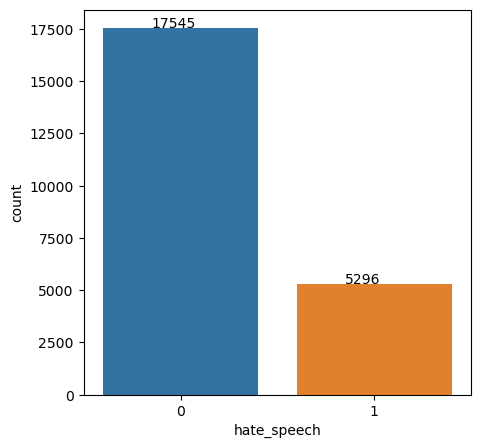

In [18]:
plt.figure(figsize=(5,5))
ax=sns.countplot(x=df['hate_speech'],data=df,order=df['hate_speech'].value_counts().index)
for p,label in zip(ax.patches,df['hate_speech'].value_counts()):
    ax.annotate(label,(p.get_x()+0.25,p.get_height()+0.5))

## Data Cleaning

### Remove NaN values and drop comments which are deleted or removed

In [19]:
size_col0 = len(df['comment'])
size_col1 = df['comment'].count()
size_col2 = len(df['hate_speech'])
size_col3 = df['hate_speech'].count()
print("Comment Length: ", size_col0)
print("Comment Count: ", size_col1)
print("Hate Speech Length: ", size_col2)
print("Hate Speech Count: ",size_col3)

Comment Length:  22841
Comment Count:  22757
Hate Speech Length:  22841
Hate Speech Count:  22841


In [20]:
df = df.dropna().loc[(df['comment'] != '[deleted]') & (df['comment'] != '[removed]')]

In [21]:
size_col0 = len(df['comment'])
size_col1 = df['comment'].count()
size_col2 = len(df['hate_speech'])
size_col3 = df['hate_speech'].count()
print("Comment Length: ", size_col0)
print("Comment Count: ", size_col1)
print("Hate Speech Length: ", size_col2)
print("Hate Speech Count: ",size_col3)

Comment Length:  22246
Comment Count:  22246
Hate Speech Length:  22246
Hate Speech Count:  22246


### Save the cleaned dataset

In [22]:
df.to_csv('Reddit_Cleaned.csv', index=False)
print("File saved.")

File saved.


### Convert to lowercase 


#### In tokenization a sentence word by word, same word represented in upper and lower case notations are identified as different words. For example, ‘Basic’ and ‘basic’ are considered different but they both are same,because python is case-sensitive,it adds complexity to model, to simplify it we do lowercasing.

In [ ]:
df['comment'][1]

In [23]:
df['comment']=df['comment'].str.lower()
df.head()

,comment,hate_speech
0,a subsection of retarded hungarians? ohh boy. ...,1
1,hiii. just got off work. 444 is mainly the typ...,0
2,wow i guess soyboys are the same in every country,0
3,owen benjamin's soyboy song goes for every cou...,0
4,"> ""y'all hear sumn?"" by all means i live in a...",0


In [ ]:
df['comment'][1]

### Removing HTML Tags 

#### Removing unwanted data from the text, let’s take the case of scraping data from web, where we get html tags which are unnecessary for the data,those should be removed.

In [24]:
def remove_html_tags(text):
    if isinstance(text, float) or text is None:  # Check for float or None and convert to empty string
        text = ''
    pattern = re.compile(r'<.*?>')
    return pattern.sub('', text)

df['comment'] = df['comment'].astype(str)
df['comment'] = df['comment'].apply(remove_html_tags)
df.head()

,comment,hate_speech
0,a subsection of retarded hungarians? ohh boy. ...,1
1,hiii. just got off work. 444 is mainly the typ...,0
2,wow i guess soyboys are the same in every country,0
3,owen benjamin's soyboy song goes for every cou...,0
4,"> ""y'all hear sumn?"" by all means i live in a...",0


### Removing URL

In [25]:
def remove_url(text):
    pattern=re.compile(r'https?://\s+|www.\.\S+')
    return pattern.sub(r'',text)

df['comment']=df['comment'].apply(remove_url)
df.head()

,comment,hate_speech
0,a subsection of retarded hungarians? ohh boy. ...,1
1,hiii. just got off work. 444 is mainly the typ...,0
2,wow i guess soyboys are the same in every country,0
3,owen benjamin's soyboy song goes for every cou...,0
4,"> ""y'all hear sumn?"" by all means i live in a...",0


### Stop words Removal - Words which help in sentence formation, but does not aid any meaning to the sentence like ‘a’, ‘an’, ‘the’, ‘is’ and so on.

In [ ]:
df['comment'][1]

In [26]:
stop_words = get_stop_words('en')
def stop_words_removal(text):
    new_text=[]
    for word in text.split():
        if word in get_stop_words('en'):
            new_text.append('')
        else:
            new_text.append(word)
    return ' '.join(new_text)

df['comment']=df['comment'].apply(stop_words_removal)
df.head()

,comment,hate_speech
0,subsection retarded hungarians? ohh boy. bra...,1
1,hiii. just got work. 444 mainly typa guys ...,0
2,wow guess soyboys every country,0
3,owen benjamin's soyboy song goes every countr...,0
4,"> ""y'all hear sumn?"" means live small tow...",0


In [ ]:
df['comment'][1]

### Removing Punctuations 

#### When we are tokenizing the sentences, punctuations become different words. For example, "Hello! how are you?" is tokenized as [Hello , !, how ,are, you,?]. Here punctuation marks are taken as different words. It adds complexity to the model by performing more operations to the code and punctuations does not attribute any meaning to the sentence.

In [ ]:
df['comment'][1]

In [27]:
print(string.punctuation)
exclude=string.punctuation

def remove_punctuation(text):
    for char in exclude:
        text=text.replace(char,'')
    return text

df['comment']=df['comment'].apply(remove_punctuation)
df.head()

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


,comment,hate_speech
0,subsection retarded hungarians ohh boy brace...,1
1,hiii just got work 444 mainly typa guys im...,0
2,wow guess soyboys every country,0
3,owen benjamins soyboy song goes every country...,0
4,yall hear sumn means live small town rn ...,0


In [ ]:
df['comment'][1]

### Chat Word Treatment 

#### Words like ROFL,LMAO,FYI,GD,ASAP, are found in chat messages of many social media platforms like WhatsApp, Instagram, Twitter. While summarizing the text, to understand the meaning of the word, these short words should be replaced with long forms. 

In [28]:
chat_words={'AFAIK': 'As Far As I Know',
'AFK':'Away From Keyboard',
'ASAP':'As Soon As Possible',
'ATK':'At The Keyboard',
'ATM':'At The Moment',
'A3':'Anytime, Anywhere, Anyplace',
'BAK':'Back At Keyboard',
'BBL': 'Be Back Later',
'BBS': 'Be Back Soon',
'BFN': 'Bye For Now',
'B4N': 'Bye For Now',
'BRB': 'Be Right Back',
'BRT': 'Be Right There',
'BTW': 'By The Way',
'B4': 'Before',
'B4N': 'Bye For Now',
'CU':'See You',
'CUL8R':'See You Later',
'CYA': 'See You',
'FAQ': 'Frequently Asked Questions',
'FC': 'Fingers Crossed',
'FWIW': 'For What Its Worth',
'FYI': 'For Your Information',
'GAL': 'Get A Life',
'GG': 'Good Game',
'GN' : 'Good Night',
'GMTA': 'Great Minds Think Alike',
'GR8': 'Great!',
'G9': 'Genius',
'IC': 'I See',
'ICQ': 'I Seek you (also a chat program)',
'ILU': 'I Love You',
'IMHO': 'In My Honest/Humble Opinion',
'IMO':'In My Opinion',
'IOW':'In Other Words',
'IRL': 'In Real Life',
'KISS':'Keep It Simple, Stupid',
'LDR':'Long Distance Relationship',
'LMAO':'Laugh My A.. Off',
'LOL':'Laughing Out Loud',
'LTNS': 'Long Time No See',
'L8R': 'Later',
'MTE': 'My Thoughts Exactly',
'M8': 'Mate',
'NRN': 'No Reply Necessary',
'OIC':'Oh I See',
'PITA':'Pain In The A..',
'PRT': 'Party',
'PRW':'Parents Are Watching',
'QPSA':	'Que Pasa?',
'ROFL':'Rolling On The Floor Laughing',
'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
'ROTFLMAO':'Rolling On The Floor Laughing My A.. Off',
'SK8':'Skate',
'STATS':'Your sex and age',
'ASL':'Age, Sex, Location',
'THX':'Thank You',
'TTFN':'Ta-Ta For Now!',
'TTYL':'Talk To You Later',
'U':'You',
'U2':'You Too',
'U4E':'Yours For Ever',
'WB':'Welcome Back',
'WTF':'What The F...',
'WTG':'Way To Go!',
'WUF':'Where Are You From?',
'W8':'Wait...',
'7K':'Sick'}

In [29]:
df['comment'][16]

' apparently  don’t study    either    had you’d know   muchanticipated modern reformation  islam will never actually happen  i’m wasting  time   think marxism   positive influence   christian west   retarded last  checked atheists still need food lol'

In [30]:
def chat_word(text):
    new_text=[]
    for word in text.split():
        if word.upper() in chat_words:
            new_text.append(chat_words[word.upper()])
        else:
            new_text.append(word)
            
    return " ".join(new_text)

df['comment']=df['comment'].apply(chat_word)
df.head()

,comment,hate_speech
0,subsection retarded hungarians ohh boy brace l...,1
1,hiii just got work 444 mainly typa guys imagin...,0
2,wow guess soyboys every country,0
3,owen benjamins soyboy song goes every country ...,0
4,yall hear sumn means live small town rn for wo...,0


In [31]:
df['comment'][16]

'apparently don’t study either had you’d know muchanticipated modern reformation islam will never actually happen i’m wasting time think marxism positive influence christian west retarded last checked atheists still need food Laughing Out Loud'

### Handling Emoji’s 

#### While analyzing chatting messages, for text classification or sentiment analysis, emoji’s particularly have a meaning, we can replace emoji expression with their corresponding meaning. If our problem statement does not have anything to do with sentiments or feelings,we can remove them. 

In [32]:
def emoji_removal(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['comment']=df['comment'].apply(emoji_removal)
df.head()

,comment,hate_speech
0,subsection retarded hungarians ohh boy brace l...,1
1,hiii just got work 444 mainly typa guys imagin...,0
2,wow guess soyboys every country,0
3,owen benjamins soyboy song goes every country ...,0
4,yall hear sumn means live small town rn for wo...,0


### Tokenization - Breaking the text into sentences and words, we understand context of the text and we can also the find the topic of the text and many more.

In [ ]:
df['comment'][17]

In [33]:
df['comment']=df['comment'].apply(word_tokenize)
df.head()

,comment,hate_speech
0,"[subsection, retarded, hungarians, ohh, boy, b...",1
1,"[hiii, just, got, work, 444, mainly, typa, guy...",0
2,"[wow, guess, soyboys, every, country]",0
3,"[owen, benjamins, soyboy, song, goes, every, c...",0
4,"[yall, hear, sumn, means, live, small, town, r...",0


In [ ]:
df['comment'][17]

### Stemming

#### Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language. Inflection is the modification of a word to express different grammatical categories such as tense, voice, aspect, person, gender and mood. In stemming, inflection is not cared much, other than the reducing the word to its stem.



In [34]:
df['comment'][17]

['good',
 'answer',
 'print',
 'pin',
 'wall',
 'top',
 'unconstructive',
 'fallacies',
 'internet']

In [36]:
df['comment'] = df['comment'].apply(lambda x: [stemmer.stem(y) for y in x]) 
df.head()

,comment,hate_speech
0,"[subsect, retard, hungarian, ohh, boy, brace, ...",1
1,"[hiii, just, got, work, 444, main, typa, guy, ...",0
2,"[wow, guess, soyboy, everi, countri]",0
3,"[owen, benjamin, soyboy, song, goe, everi, cou...",0
4,"[yall, hear, sumn, mean, live, small, town, rn...",0


In [37]:
df['comment'][17]

['good',
 'answer',
 'print',
 'pin',
 'wall',
 'top',
 'unconstruct',
 'fallaci',
 'internet']

### Lemmatization


#### Lemmatization unlike stemming reduces inflected words properly ensuring that the root word belongs to the language. In the lemmatization root word is called lemma.



In [38]:
df['comment'][17]

['good',
 'answer',
 'print',
 'pin',
 'wall',
 'top',
 'unconstruct',
 'fallaci',
 'internet']

In [39]:
df['comment'] = df['comment'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
wnl=WordNetLemmatizer()
def lemmatizing(text):
    return " ".join([wnl.lemmatize(word,pos='v') for word in text.split('  ')])

df['comment']=df['comment'].apply(lemmatizing)
df.head()

,comment,hate_speech
0,subsect retard hungarian ohh boy brace livid b...,1
1,hiii just got work 444 main typa guy imagin wr...,0
2,wow guess soyboy everi countri,0
3,owen benjamin soyboy song goe everi countri amaz,0
4,yall hear sumn mean live small town rn for wor...,0


In [40]:
df['comment'][17]

'good answer print pin wall top unconstruct fallaci internet'

### Remove numbers and autocorrect


In [ ]:
df['comment'][1]

In [41]:
def remove_numbers(text):
    if isinstance(text, str):
        return re.sub(r'\d+', '', text)
    return text

df['comment'] = df['comment'].map(remove_numbers)
df.head()

,comment,hate_speech
0,subsect retard hungarian ohh boy brace livid b...,1
1,hiii just got work main typa guy imagin write...,0
2,wow guess soyboy everi countri,0
3,owen benjamin soyboy song goe everi countri amaz,0
4,yall hear sumn mean live small town rn for wor...,0


In [42]:
df['comment'][1]

'hiii just got work  main typa guy imagin write us stupid site basic just tri fit western european us big citi hipster rich kid budapest feel brave journalist hero'

In [ ]:
spell = Speller()
# Autocorrect text
def autocorrect_text(text):
    if isinstance(text, str):
        return spell(text)
    return text

# Apply autocorrect in parallel
def parallel_apply(data, func, workers=4):
    with ThreadPoolExecutor(max_workers=workers) as executor:
        results = list(tqdm(executor.map(func, data), total=len(data)))
    return results

# Apply the autocorrect function with parallel processing
df['comment'] = parallel_apply(df['comment'], autocorrect_text)
df.head()

  0%|          | 0/22246 [00:00<?, ?it/s]

In [ ]:
df['comment'][1]

### Save the Preprocessed Dataset

In [41]:
df.to_csv('Reddit_Preprocessed.csv', index=False)
print("File saved.")

File saved.
